In [132]:
# import packages
import numpy as np
from astropy import units as u
import astropy.constants as const

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

## What we're doing in math terms

We assume the two-body reference frame, calculating everything from the rest frame of the star.

First, here's our equation for P, from Kepler's 3rd law:
$$ P = \sqrt{\frac{4\pi^{2}a^{3}}{GM_{*}}} $$ 

$r_{0} = a(1 - e)$ and $\theta_{0} = 0$

For our computation, we set a grid size `n` and compute $r$ and $\theta$ at each time step from 0 to P in `n` steps. If we want to see the behavior over multiple orbits, we scale the time array by `nP`

At each time step, we calculate $\Delta\theta = \sqrt{GM_{*}}\frac{(1 + ecos\theta)^{2}}{a(1-e^{2})^{3/2}}\Delta t$ using the previous step's $~\theta$ to get $\theta_{current} = \theta_{previous} + \Delta\theta$

We can calculate $r(\theta_{current}) = \frac{a(1 - e^{2})}{1 +  e cos\theta}$

    dtheta = ((np.sqrt(const.G * mstar)) * (1 + e * np.cos(current_theta))**2 * ( a * (1 - e**2))**(-3/2) * dt).decompose()


We also attempt to find transit times for an observer positioned at periastron.

We use equation (14) from Winn for a **circular orbit**:

$$ T_{tot} = \frac{P}{\pi}sin^{-1}[\frac{R_*}{a}\frac{\sqrt{(1+k)^2 - b^2}}{sin~i}] $$

In [180]:
# set system initial conditions

mstar = 1 * u.M_sun  # stellar mass
rstar = 1 * u.R_sun  # stellar radius
mp = 1 * u.M_jupiter # planet mass
rp = 1 * u.R_jup # planet radius
a = 5 * u.AU  # semi-major axis
e = 0.6  # orbital eccentricity
i = np.pi * 0.5  # assume we are observing in-plane, i.e. inclination = 90 deg
omega = np.pi * 0.5
theta0 = 0.  # initial longitude

n = 10000  # number of steps

P = np.sqrt(((4*np.pi**2) / (const.G * mstar)) * a**3 )  # period from kepler's third law

# set observation initial conditions

dt = P / n     # duration of time step
print(f"dt = {dt.to(u.hr)} for {n} steps")
nP = 1 # number of periodts the time goes for
t_array = np.linspace(0, P*nP, n*nP)  # array of time steps from 0 to P
r0 = a * (1 - e)  # initial planet position, default: periastron
b = 0  # assume planet is passing right through the middle of the disk of the star

# using v_p, rstar, can get tdur of transit time
#   unless orbit is very elliptical, vp will not change that much over the course of the transit, 
#   Winn, 2.3 eq 14 (p.58

# We assume b = 0 

dur_circ = ((P / (np.pi * u.rad)) * 
       np.arcsin((rstar / a) * np.sqrt((1 + (rp/rstar))**2 - b**2) / (np.sin(i)))).to(u.hr)
correction = np.sqrt(1 - e**2) / (1 + e*np.sin(omega)) # correct for e > 0
dur = dur_circ * correction
print(f"Transit duration for circular orbit: {dur}")
print(f"Geometric transit duration: {dur} (correction: {correction})")
print(f"Points in transit: {int(np.floor((dur / dt).decompose()))}") # points in transit

# compare to when planet is in y-value of star disk at transit and eclipse

# initialize array of longitudes for each time step
thetas = np.zeros(len(t_array))
thetas[0] = theta0

# initialize array of radii
r = np.zeros(len(t_array)) * u.AU
r[0] = r0

# initialize x, y arrays
x, y = np.zeros(len(t_array)) * u.AU, np.zeros(len(t_array)) * u.AU
x[0] = r0 * np.cos(theta0)
y[0] = r0 * np.sin(theta0)

# debug: track each theta, dtheta
#current_thetas = np.zeros(len(t_array))
#dthetas = [0.]
debug = False

# calculate thetas for conjunction
t_conj = (P*np.arange(0,nP + 1)).to(u.yr)
# if dt is 1hr, how many points should be during transit (on disk of star)? should be ~31
t_ingress = (P*np.arange(0,nP + 1)).to(u.yr) - dur*0.5
t_egress = (P*np.arange(0,nP + 1)).to(u.yr) + dur*0.5


# calculate r, theta at each time step
for i in np.arange(len(t_array)):
    # get time
    t = t_array[i]
    # get current longitutde
    if debug: print(f"i: {i}, t: {t.decompose()}")
    current_theta = thetas[i] # thetas[np.where(t_array == t)[0][0]]  # current value of theta
    # current_thetas.append(current_theta) # debug only
    
    # calculate dtheta
    dtheta = ((np.sqrt(const.G * mstar)) * (1 + e * np.cos(current_theta))**2 * ( a * (1 - e**2))**(-3/2) * dt).decompose()
    # dthetas.append(dtheta)  # debug only
    
    # add to get new longitude 
    new_theta = current_theta + dtheta.value
    # save the new theta longitude to the array
    if i+1 == len(t_array):
        pass
    else:
        thetas[i+1] = new_theta
    
    # because we know theta, we can get the position
    current_r = a * (1 - e**2) / (1 + e * np.cos(current_theta))
    r[i] = current_r
    x[i] = current_r * np.cos(current_theta)
    y[i] = current_r * np.sin(current_theta)
    
    #print(f"time = {t:.3}, theta + dtheta =  {current_theta:.3} + {dtheta:.3} = {new_theta:.3}, r = {current_r}")

#thetas = thetas[:-1]
#dthetas = dthetas[:-1]

dt = 9.800871048449409 h for 10000 steps
Transit duration for circular orbit: 15.999025554510787 h
Geometric transit duration: 15.999025554510787 h (correction: 0.5)
Points in transit: 1


In [182]:
left_edge, right_edge = rstar.to(u.AU).value * np.array([-1,1])

debug = False 

x_orbit = np.array([q.value for q in x])  # x-dimension of ellipse (along major axis)
y_orbit = np.array([q.value for q in y])  # y-dimension of ellipse (along minor axis)

# select y positions when center of planet is in front of disk of star
mask_overlap = (y_orbit >= left_edge) & (y_orbit <= right_edge)
# print("planet + star overlap: \n", list(zip(x_orbit[mask_overlap], y_orbit[mask_overlap])))
print(f"planet + star overlap at {len(y_orbit[mask_overlap])} time points")

# select y positions when planet is _transiting_
transit_y = y_orbit[mask_overlap & (x_orbit > 0)]
if debug: print(f"y positions, planet in front of star ({len(transit_y)}):", transit_y)

# select y positions 
mask_around_transit = (y_orbit >= left_edge*2) & (y_orbit <= right_edge*2) & (x_orbit > 0)
around_transit_y = y_orbit[mask_around_transit]

# select y positions when planet is in _eclipse_
eclipse_y = y_orbit[mask_overlap & (x_orbit < 0)]
if debug: print(f"y positions, planet behind star: ({len(eclipse_y)})", eclipse_y)

# todo: use mask to find what RV points are in transit
# print(v_star[mask_overlap], r"Needs to be projected in sin $\theta$")
#   there should be ~3 points in front, so check indices issue
#   projected velocity should be zero at transit and eclipse 
#   using dtheta will give correct velocity vector


overlap_theta = np.array(thetas)[mask_overlap]
overlap_r = np.array([q.value for q in r])[mask_overlap]

planet + star overlap at 7 time points


In [275]:
## now we think about the star as a carton of neapolitan ice cream or 
## the French national flag 🇫🇷

x_boundaries = [left_edge, left_edge*(1/3), right_edge*(1/3), right_edge]

testN = 10000
pl_r = rp.to(u.AU).value
st_r = rstar.to(u.AU).value

# random points on disk of star
test_x = np.random.random(testN) * (right_edge - left_edge) + left_edge 
test_y = np.random.random(testN) * (right_edge - left_edge) + left_edge
test_r = np.sqrt(test_x**2 + test_y**2)

# select only points on disk of star
star_mask = test_r < st_r
star_xtest = test_x[star_mask]
star_ytest = test_y[star_mask]
starN = len(star_xtest)

pl_y = 0 # b = 0, so planet is in the plane of the observer

# save all the planet-masked dots
boop_x, boop_y = [],[]

# blues
blue_x, blue_y = [],[]

# whites

# reds

# tally up the change in RV due to Ross-McL
drvs = np.zeros(len(around_transit_y))

# of points on star disk, select points on disk of planet as a function of time
for position in around_transit_y:
    test_rp = np.sqrt((star_xtest - position)**2 + (star_ytest - pl_y)**2)
    in_planet_mask =  test_rp < pl_r
    pl_xtest = star_xtest[in_planet_mask]
    pl_ytest = star_ytest[in_planet_mask]
    
    # blue
    # looks more red-shifted (moving away from viewer)
    blue_mask = (pl_xtest > x_boundaries[0]) & (pl_xtest < x_boundaries[1])
    blue_blocked = len(pl_xtest[blue_mask])/ starN
    drv -= blue_blocked
    print(f"{blue_blocked*100}% blue light blocked")
    
    # white
    # no contribution to red/blue shift
    white_mask = (pl_xtest > x_boundaries[1]) & (pl_xtest < x_boundaries[2])
    white_blocked = len(pl_xtest[white_mask]) / starN
    print(f"{white_blocked*100}% white light blocked")
    
    # red
    # looks more blue-shifted (moving towards viewer)
    red_mask = (pl_xtest > x_boundaries[2]) & (pl_xtest < x_boundaries[3])
    red_blocked = len(pl_xtest[red_mask]) / starN
    drv += red_blocked
    print(f"{red_blocked*100}% red light blocked")
    
    drvs[position] = drv
    print(f"total Ross-McL dRV at this position: {drv}\n")
    

# how much of the star's light is that? 
#    starlight * (area planet / area star)
#    if blue area: subtract
#    if red area: add
#    if hwite area: nothing



0.0% blue light blocked
1.015615081883966% white light blocked
0.0% red light blocked


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [281]:
foo = np.zeros(len(around_transit_y))
foo[0] = 12
foo

array([12.,  0.,  0.])

NameError: name 'drvs' is not defined

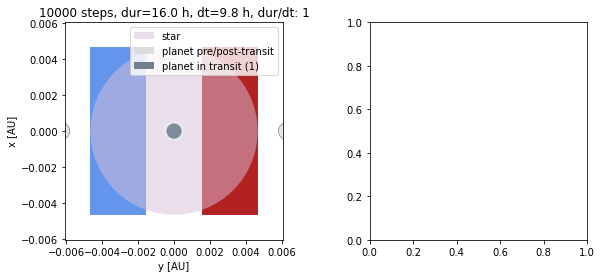

In [274]:
fig = plt.figure(figsize=(10,4))

# track R-M on star disk
ax = fig.add_subplot(121, aspect='equal')

"""
# back when I was thinking about planets as squares
for i in np.arange(len(transit_y)):
    ax.add_patch(Rectangle((transit_y[i]-rp.to(u.AU).value,-rp.to(u.AU).value),
                           2*rp.to(u.AU).value,2*rp.to(u.AU).value,
                           color='slategrey',lw=2,alpha=0.8,zorder=9))
ax.add_patch(Rectangle((transit_y[0]-rp.to(u.AU).value,-rp.to(u.AU).value),
                       2*rp.to(u.AU).value,2*rp.to(u.AU).value,
                       color='pink',lw=2,alpha=0.8,zorder=9))
"""
# rotating regions of star
rect_width = 2*rstar.to(u.AU).value / 3
ax.add_patch(Rectangle((boundaries[0],-right_edge),rect_width, 2*right_edge,
                       fc='cornflowerblue',zorder=1))
ax.add_patch(Rectangle((boundaries[1],-right_edge),rect_width, 2*right_edge,
                       fill=None,ec='white',zorder=1))
ax.add_patch(Rectangle((boundaries[2],-right_edge),rect_width, 2*right_edge,
                       fc='firebrick',zorder=1))

# circular star footprint
ax.add_artist(plt.Circle((0,0),rstar.to(u.AU).value,fc='thistle',alpha=0.5,label='star'))
# for legend reasons only
_planet = ax.add_artist(plt.Circle((0,0),rp.to(u.AU).value,
                                    fc='gainsboro',label='planet pre/post-transit'))
planet = ax.add_artist(plt.Circle((0,0),rp.to(u.AU).value,
                                   fc='slategrey',label=f'planet in transit ({len(transit_y)})'))


# add planet positions before/after transit
for i in np.arange(len(around_transit_y)):
    ax.add_artist(plt.Circle((around_transit_y[i],0),rp.to(u.AU).value,
                              ec='slategrey',fc='gainsboro', alpha=0.7))
# add planet positions in transit
for i in np.arange(len(transit_y)):
    ax.add_artist(plt.Circle((transit_y[i],0),rp.to(u.AU).value,
                            ec='white',lw=2, fc='slategrey',alpha=0.8))


# formatting 
ax.set_xlabel("y [AU]")
ax.set_ylabel("x [AU]")
ax.set_title(f"{n} steps, dur={dur.to(u.hr):.3}, dt={dt.to(u.hr):.3}, dur/dt: {int(np.floor((dur / dt).decompose()))}")

ax.set_xlim(left_edge*1.3,right_edge*1.3)
ax.set_ylim(left_edge*1.3,right_edge*1.3)

plt.legend(loc='upper right')

ax2 = fig.add_subplot(122, aspect='equal')
ax2.scatter(drvs)


# vrot star ~ 1.6 km/s

In [187]:
((right_edge - left_edge)*u.AU).to(u.R_sun)

<Quantity 2. solRad>

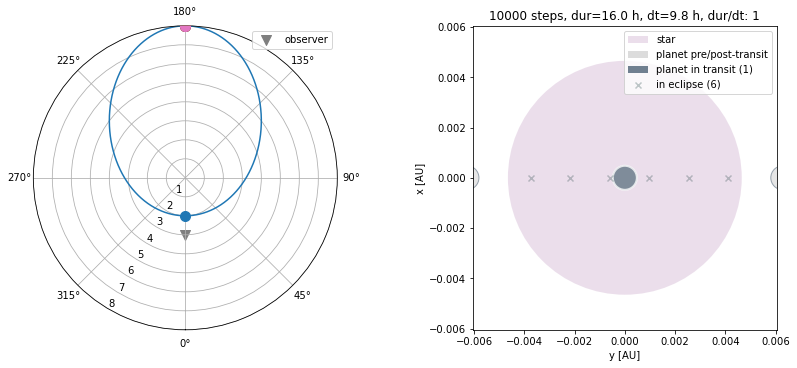

In [252]:
## !! HEY !! you need to run the cells below before the RV plot will work !! ##

# set up figure
fig = plt.figure(figsize=(12,5),constrained_layout=True)
  
# plot path of ellipse
ax = fig.add_subplot(121, projection='polar')
ax.plot(thetas, [i.value for i in r]) #, s=2)
for i in np.arange(len(overlap_theta)):
    ax.scatter(overlap_theta[i], overlap_r[i], s=100, zorder=10)
# plot observer
ax.scatter(0,r[0]*1.5, marker='v',s=100, label='observer')

# add labels
ax.set_rmax(8)
#ax.set_rticks([2,4,6,8])  # Fewer radial ticks ([0.5, 1, 1.5, 2])
ax.set_rlabel_position(-30.5)  # Move radial labels away from plotted line
ax.set_theta_zero_location("S")
ax.legend(loc='upper right')
ax.grid(True)

ax2 = fig.add_subplot(122, aspect='equal')
# ax2.axis([-2, 2, -2, 2])
# ax2.axis("equal")
star = ax2.add_artist(plt.Circle((0,0),rstar.to(u.AU).value,fc='thistle',alpha=0.5,label='star'))

# for legend reasons only
_planet = ax2.add_artist(plt.Circle((0,0),rp.to(u.AU).value,
                                    fc='gainsboro',label='planet pre/post-transit'))
planet = ax2.add_artist(plt.Circle((0,0),rp.to(u.AU).value,
                                   fc='slategrey',label=f'planet in transit ({len(transit_y)})'))

# add points before/after transit
for i in np.arange(len(around_transit_y)):
    ax2.add_artist(plt.Circle((around_transit_y[i],0),rp.to(u.AU).value,
                              ec='slategrey',fc='gainsboro', alpha=0.7))
# add points in transit
for i in np.arange(len(transit_y)):
    ax2.add_artist(plt.Circle((transit_y[i],0),rp.to(u.AU).value,
                            ec='white',lw=2, fc='slategrey',alpha=0.8))
# add points in eclipse
ax2.scatter(eclipse_y, np.zeros(len(eclipse_y)),
            alpha=0.3, color='darkslategrey', marker='x', label=f'in eclipse ({len(eclipse_y)})')

# formatting 
ax2.set_xlabel("y [AU]")
ax2.set_ylabel("x [AU]")
ax2.set_title(f"{n} steps, dur={dur.to(u.hr):.3}, dt={dt.to(u.hr):.3}, dur/dt: {int(np.floor((dur / dt).decompose()))}")

ax2.set_xlim(left_edge*1.3,right_edge*1.3)
ax2.set_ylim(left_edge*1.3,right_edge*1.3)

ax2.legend(loc='upper right')


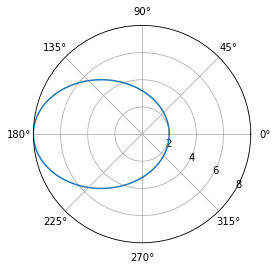

In [189]:
# plot path of ellipse
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot(thetas, [i.value for i in r])

# add labels
ax.set_rmax(7)
ax.set_rticks([2,4,6,8])  # Fewer radial ticks ([0.5, 1, 1.5, 2])
ax.set_rlabel_position(-30.5)  # Move radial labels away from plotted line
ax.grid(True)


Text(0, 0.5, 'dtheta')

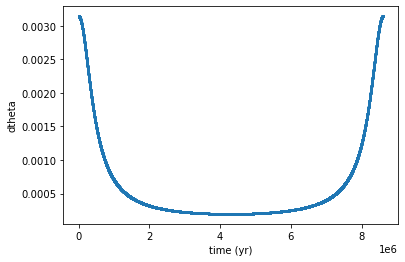

In [190]:
# plot dtheta for each time step
#   for a circular orbit, the plot will be a flat line 
plt.scatter(t_array[1:], np.diff(thetas),s=3)

# add labels
plt.xlabel("time (yr)")
plt.ylabel("dtheta")


$$ v_{p} = \frac{dr}{dt}\hat{r} + r\frac{d\theta}{dt}\hat{\theta} $$


$$ v_{p} = \sqrt{\frac{GM}{a(1-e^{2})}}\frac{esin\theta}{1 + ecos\theta} + \sqrt{\frac{GM}{a(1-e^{2})}}(1 + e cos\theta) $$

For now, we just consider the second term:

$$ v_{p} = \sqrt{\frac{GM}{a(1-e^{2})}}(1 + e cos\theta) $$

$$ v_{*} = \frac{m_{p}}{m_{p} + m_{*}}v_{p}$$ 

Applying some trigonometry, the  line-of-sight velocity   for an observer at periastron is a component of the above $v_{*}$:

$$ v_{*,radial} =  v_{*,total}sin\theta $$

_(I think below is another way to calculate the stellar velocity, but I'm not going to worry about it too much for now)_

Now attempting to calculate $\frac{dz}{dt}$:

$$ \frac{dz}{dt} = \frac{\frac{2\pi}{P}a sin(i)}{\sqrt{1 - e^{2}}}(cos(\omega + f) + e~cos(\omega))$$

$$ v_{r} = V_{z}  + \frac{m_{p}}{m_{p} + m_{star}}\frac{\frac{2\pi}{P}a sin(i)}{\sqrt{1 - e^{2}}}(cos(\omega + f) + e~cos(\omega)) $$

$$ v_{r} = V_{z}  + K(cos(\omega + f) + e~cos(\omega)) $$

For simplicity, we assume $V_{z}$ (proper motion velocity?) $ = 0 $
and 
$$ K = \frac{m_p}{m_p + m_{star}}\frac{\frac{2\pi}{P}asin(i)}{\sqrt{1 - e^2}} $$ 




In [202]:
#v_p = (np.sqrt((const.G * mstar)/(a * (1 - e**2)))*(np.sqrt(np.abs(e*np.sin(thetas))) + np.sqrt(1 + e*np.cos(thetas)))).decompose()
quantity = np.sqrt((const.G * mstar) / (a * (1 - e**2) )) # K

# v_p = ((quantity * ((e * np.sin(thetas))/(1 + e * np.cos(thetas)))) + (quantity * (1 + e * np.cos(thetas)))).decompose()

# we only consider the term in the theta direction
v_p = (quantity * (1 + e * np.cos(thetas))).decompose()

v_star = (mp/(mp + mstar) * v_p).decompose()

rv = np.sin(thetas) * v_star

Text(0, 0.5, '$V_{star} [m/s]$')

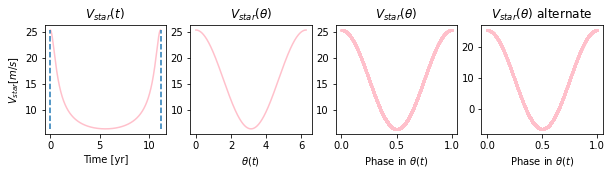

In [203]:
# plot total velocity quantities

## plot planet total velocity vs time
#plt.plot(t_array,v_p[:-1],label=r"$v_{p}$")

# set up plot
plt.rc('font',size=10) 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(10,2))

# plot star velocity vs time
ax1.plot(t_array.to(u.yr),v_star,label=r"$v_{*}$",c='pink')
# plot regions where planet transits
for t in t_conj:
    ylow, yhigh = v_star.value.min(), v_star.value.max()
    ax1.vlines(t.value, ylow, yhigh,linestyle='dashed')
# formatting
ax1.set_xlabel("Time [yr]")
ax1.set_title(r"$V_{star}(t)$")

# plot star total velocity vs. thetas
ax2.plot(thetas, v_star,label=r'$v_{star}$', c='pink')
ax2.set_xlabel(r"$\theta(t)$")
ax2.set_title(r"$V_{star}(\theta)$")

# plot phase-folded star total velocity vs. thetas
folded_thetas = [(t/(2*np.pi)) - (t/(2*np.pi) - ((t/(np.pi*2)) % (1)) )for t in thetas ]
ax3.scatter(folded_thetas, v_star,label=r'$v_{star}$', c='pink',s=3)
ax3.set_xlabel(r"Phase in $\theta(t)$")
ax3.set_title(r"$V_{star}(\theta)$")

# calculate the line-of-sight radial velocity
inc = np.pi/2
arg_peri = 0.
dzdt = ((np.pi * 2)/P)* a * np.sin(inc)* np.power(1 - e**2, -0.5) * \
    (np.cos([arg_peri + t for t in thetas]) +  e * np.cos(arg_peri) ) 
rvz = ((mp/(mp + mstar)) * dzdt).decompose()
ax4.scatter(folded_thetas, rvz, s=3, c='pink')
ax4.set_xlabel(r"Phase in $\theta(t)$")
ax4.set_title(r"$V_{star}(\theta)$ alternate")


# add labels
#for ax in [ax1, ax2, ax3, ax4]: ax.set_ylabel(r"$V_{star} [m/s]$")
ax1.set_ylabel(r"$V_{star} [m/s]$")



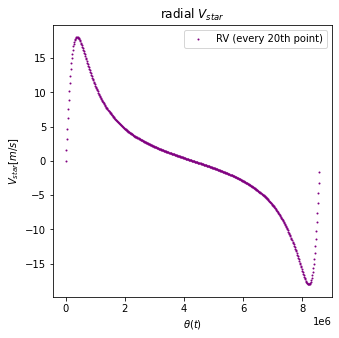

In [207]:
# figure setup
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

# actual radial velocity
skip = 20
ax.scatter(t_array[::skip], rv[::skip],
           s=1, c='purple',label=f"RV (every {skip}th point)")
ax.set_title(r"radial $V_{star}$")
ax.set_xlabel(r"$\theta(t)$")
ax.set_ylabel(r"$V_{star} [m/s]$")
plt.legend()

# toy model for star

star as a carton of neapolitan ice cream: 
 * bubble gum (moving twoards), vanilla, cherry (moving away)
 
rough velocity : $ \frac{2\pi R_*}{star rotation periods}$

R-M amplitude:
* stellar rotation speed (slower - bigger amplitude)
* (Rp/Rstar)**2

# dreams 

* sample of M dwarfs with activity information:
    * Newton+, has spectra info
        * active: has $H\alpha$, which means has lots of ionization
        * m dwarfs never die! we can assume the population is close to the M dwarf IMF
    * Chontos?